In [3]:
import os
import re
import json
import yaml
import argparse
from test_metric import process_trial
from wbfm.utils.projects.finished_project_data import ProjectData
import matplotlib.pyplot as plt


def extract_val_loss(trial_path):
    stats_path = os.path.join(trial_path, "log", "stats.json")
    if not os.path.isfile(stats_path):
        print(f"No stats.json found at {stats_path}")
        return None

    try:
        with open(stats_path, "r") as f:
            stats = json.load(f)
        if len(stats) >= 2 and "val_loss" in stats[-2]:
            return stats[-2]["val_loss"]
        else:
            print(f"{stats_path} too short or missing 'val_loss'")
            return None
    except Exception as e:
        print(f"Error reading {stats_path}: {e}")
        return None


def discover_trials(trial_parent_dir):
    """
    Discovers trial numbers from folders named 'trial_<number>' in the given directory.
    """
    trials = []
    for entry in os.listdir(trial_parent_dir):
        entry_path = os.path.join(trial_parent_dir, entry)
        if os.path.isdir(entry_path) and entry.startswith("trial_"):
            match = re.match(r"trial_(\d+)", entry)
            if match:
                trials.append(int(match.group(1)))
    return sorted(trials)



def build_final_dict(gt_path, trial_dir, result_dir, trial_prefix):
    # Load GT once
    project_data_gt = ProjectData.load_final_project_data(gt_path)
    df_gt = project_data_gt.final_tracks

    result_dict = {
        "trial": [],
        "projector_final": [],
        "embedding_dim": [],
        "target_sz_z": [],
        "target_sz_xy": [],
        "p_RandomAffine_flip": [],
        "val_loss": [],
        "lr": [],
        "accuracy": [],
        "per_neuron_accuracy": [],
        "per_timepoint_accuracy": [],
        "misses_per_neuron_norm": [],
        "misses_per_timepoint_norm": [],
        "mismatches_per_neuron_norm": [],
        "mismatches_per_timepoint_norm": [],
    }
    trials = discover_trials(trial_dir)

    for trial_num in trials:
        trial_name = f"{trial_prefix}trial_{trial_num}"
        trial_name_config = f"trial_{trial_num}"
        trial_path = os.path.join(trial_dir, trial_name_config)
        result_path = os.path.join(result_dir, trial_name, "project_config.yaml")
        config_path = os.path.join(trial_path, "train_config.yaml")

        if not os.path.isfile(config_path):
            print(f"{trial_name}: train_config.yaml not found.")
            continue

        try:
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)

            result_dict["trial"].append(trial_num)
            result_dict["projector_final"].append(config.get("projector_final"))
            result_dict["embedding_dim"].append(config.get("embedding_dim"))
            result_dict["target_sz_z"].append(config.get("target_sz_z"))
            result_dict["target_sz_xy"].append(config.get("target_sz_xy"))
            result_dict["p_RandomAffine_flip"].append(config.get("p_RandomAffine_flip"))
            result_dict["lr"].append(config.get("lr"))

            val_loss = extract_val_loss(trial_path)
            result_dict["val_loss"].append(val_loss)

            if os.path.isfile(result_path):
                stats = process_trial(trial_num, df_gt, result_path)
                result_dict["accuracy"].append(stats.get("accuracy"))
                result_dict["per_neuron_accuracy"].append(stats.get("accuracy_per_neuron"))
                result_dict["per_timepoint_accuracy"].append(stats.get("accuracy_per_timepoint"))
                result_dict["misses_per_neuron_norm"].append(stats.get("misses_per_neuron_norm"))
                result_dict["misses_per_timepoint_norm"].append(stats.get("misses_per_timepoint_norm"))
                result_dict["mismatches_per_neuron_norm"].append(stats.get("mismatches_per_neuron_norm"))
                result_dict["mismatches_per_timepoint_norm"].append(stats.get("mismatches_per_timepoint_norm"))
            else:
                print(f"{trial_name}: project_config.yaml not found.")
                result_dict["accuracy"].append(None)
                result_dict["per_neuron_accuracy"].append(None)
                result_dict["per_timepoint_accuracy"].append(None)

        except Exception as e:
            print(f"{trial_name}: ERROR -> {e}")

    return result_dict

/lisc/home/user/schwartz/.conda/envs/wbfm_custom/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ground_truth_path = "/lisc/scratch/neurobiology/zimmer/fieseler/wbfm_projects_future/flavell_data/images_for_charlie/flavell_data.nwb"
trial_parent_dir = "/lisc/scratch/neurobiology/zimmer/wbfm/TrainedBarlow/hyperparameter_search_mit_flip/"
result_parent_dir = "/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/"
trial_prefix = "2025_07_01"

In [5]:
final_dict = build_final_dict(
        gt_path=ground_truth_path,
        trial_dir=trial_parent_dir,
        result_dir=result_parent_dir,
        trial_prefix=trial_prefix
    )

print("\nFinal dictionary:")
for k, v in final_dict.items():
    print(f"{k}: {v}")

Loaded red and green data from NWB file: (1600, 64, 284, 120)
ConfigFile  : WARNING  Could not find file None; Using hardcoded default raw data config: {'num_z_planes': 22, 'flyback_saved': False, 'num_flyback_planes_discarded': 2, 'z_step_size': 1.5, 'laser_561': 260, 'laser_488': 985, 'exposure_time': 12, 'agar': 2, 'recording_length_minutes': 8, 'ventral': 'left', 'strain': 'ZIM2165'}


ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_0 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN   168.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1.0    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2.0    NaN     9.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_1 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN    53.0    60.0     NaN     NaN     NaN     NaN     NaN     NaN   
1.0    NaN    65.0    15.0   124.0     NaN     NaN     NaN     NaN     NaN   
2.0    NaN   118.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_2 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0     NaN    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0     NaN    53.0   170.0   117.0    47.0   
2.0   47.0   157.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_3 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0     NaN   153.0     NaN   122.0   146.0     NaN   
1.0   26.0   167.0    72.0   187.0    74.0     NaN   170.0   117.0     NaN   
2.0   47.0   157.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_4 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN    53.0   173.0     NaN     NaN    14.0     NaN     NaN     NaN   
1.0    NaN    65.0     NaN     NaN     NaN    53.0     NaN     NaN     NaN   
2.0    NaN   118.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_5 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0   116.0     NaN     NaN     NaN    14.0     NaN   146.0     4.0   
1.0   26.0    14.0     NaN    46.0     NaN   169.0     NaN   117.0     NaN   
2.0   47.0     1.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_6 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids


/lisc/home/user/schwartz/wbfm/wbfm/utils/neuron_matching/utils_candidate_matches.py:252: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df1_renamed.drop(columns='unmatched_neuron', inplace=True)


     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN     NaN   118.0     NaN     NaN    98.0     NaN     NaN     NaN   
1.0    NaN     NaN    72.0     NaN     NaN    71.0     NaN     NaN     NaN   
2.0    NaN     NaN   176.0     NaN     NaN    65.0     NaN     NaN     NaN   
3.0    NaN     NaN     NaN     NaN     NaN   137.0     NaN     NaN     NaN   
4.0    NaN     NaN     NaN     NaN     NaN    60.0     NaN     NaN     NaN   

     236547  ...  239878  193467  172626  213891  213136  212363  183592  \
0.0     NaN  ...   102.0    88.0   144.0     NaN     NaN     NaN     2.0   
1.0     NaN  ...    94.0   102.0   179.0     NaN     NaN     NaN    36.0   
2.0     NaN  ...     NaN    88.0    27.0     NaN     NaN     NaN    61.0   
3.0     NaN  ...     NaN    71.0     NaN     NaN     NaN     NaN   162.0   
4.0     NaN  ...     NaN    30.0     NaN     NaN     NaN     NaN    35.0   

     268342  126889  262938  
0.0     NaN    23.0     NaN  
1.0     NaN   

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_7 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_8 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN    53.0   159.0    55.0     NaN     NaN     NaN     NaN     NaN   
1.0    NaN   164.0    43.0   124.0     NaN     NaN     NaN     NaN     NaN   
2.0    NaN   118.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_9 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0  161.0    53.0    60.0     NaN     NaN     NaN     NaN     NaN     NaN   
1.0   40.0   164.0    72.0   124.0     NaN     NaN     NaN     NaN     NaN   
2.0  145.0   118.0  

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_10 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_11 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids


/lisc/home/user/schwartz/wbfm/wbfm/utils/neuron_matching/utils_candidate_matches.py:252: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df1_renamed.drop(columns='unmatched_neuron', inplace=True)


     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    53.0   173.0     NaN     NaN     NaN     NaN     NaN     NaN   
1.0   26.0   164.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2.0   47.0   126.0    16.0     NaN     NaN     NaN     NaN     NaN     NaN   
3.0  156.0     2.0    80.0     NaN     NaN     NaN     NaN     NaN     NaN   
4.0   22.0    17.0   125.0     NaN     NaN     NaN     NaN     NaN     NaN   

     236547  ...  239878  193467  172626  213891  213136  212363  183592  \
0.0     NaN  ...    19.0   135.0   114.0   121.0     NaN    69.0   146.0   
1.0     NaN  ...     NaN   102.0    93.0    32.0     NaN   153.0   117.0   
2.0     NaN  ...     NaN    29.0     NaN     NaN     NaN   170.0   114.0   
3.0     NaN  ...     NaN    64.0     NaN     NaN     NaN    20.0    38.0   
4.0     NaN  ...     NaN    30.0     NaN     NaN     NaN    34.0    13.0   

     268342  126889  262938  
0.0   108.0     NaN     NaN  
1.0   104.0   

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_12 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN     NaN     NaN    55.0     NaN     NaN     NaN     NaN     NaN   
1.0    NaN    65.0     NaN    11.0     NaN     NaN     NaN     NaN     NaN   
2.0    NaN   118.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_13 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    53.0     NaN     NaN     NaN     NaN     NaN   146.0     NaN   
1.0   26.0    65.0     NaN     NaN     NaN     NaN     NaN   117.0     NaN   
2.0   47.0   118.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_14 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN    53.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1.0    NaN    65.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2.0    NaN   118.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_15 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_16 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0    NaN   136.0     NaN     NaN     NaN   158.0    43.0     NaN     NaN   
1.0    NaN   105.0     NaN     NaN     NaN   125.0    79.0     NaN     NaN   
2.0    NaN   171.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_17 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0     NaN   118.0    41.0     NaN     NaN   122.0   146.0     NaN   
1.0   26.0     NaN     NaN     7.0     NaN     NaN   170.0   117.0     NaN   
2.0   47.0     NaN 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_18 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_19 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_20 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_21 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_22 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_23 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_24 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_25 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0    21.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    35.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_26 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_27 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0     NaN   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0     NaN   170.0   117.0    47.0   
2.0   47.0   157.0 

ConfigFile  : INFO     =======================================
Project data for directory:
/lisc/scratch/neurobiology/zimmer/schwartz/traces_mit_flip/2025_07_01trial_28 
With raw data in directory:
None 
See self.worm_posture_class for information on behavioral parameters
Found the following data files:
============Preprocessed Videos========
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Tracking===================
tracklets:                False
final_tracks:             True
manual_tracking:          False
============Traces=====================
traces:                   True


using calc_bipartite_from_ids
     81947  134171  218356  271021  170506  167371  270971  226429  154445  \
0.0   56.0    25.0   118.0    41.0   153.0    14.0   122.0   146.0    13.0   
1.0   26.0   167.0    72.0     7.0    74.0    53.0   170.0   117.0    47.0   
2.0   47.0   157.0 

In [6]:
print(final_dict["accuracy"])

[0.7168912257640486, 0.7136093190584084, 0.9455912620855458, 0.8753307850632167, 0.841153985851912, 0.699772558244115, 0.7463851462372659, 0.9404154487434492, 0.7674343186260096, 0.7170728332497363, 0.9303232613245239, 0.7455203486863725, 0.7087361848591245, 0.7960807374993514, 0.7306242108722348, 0.9213899026237957, 0.7879646124842175, 0.8184098102634173, 0.9457555736202155, 0.9407310998495252, 0.9339727069892938, 0.9451458913468357, 0.9446443087673175, 0.9442637978449245, 0.944778352387706, 0.9411375546984451, 0.9505638480031825, 0.9477964958403238, 0.9514070256153034]


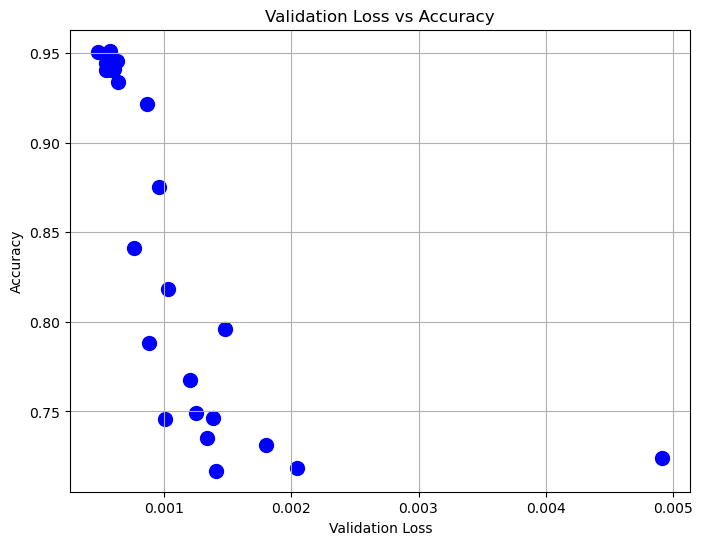

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["val_loss"], final_dict["accuracy"], c='blue', s=100)

plt.title("Validation Loss vs Accuracy")
plt.xlabel("Validation Loss")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

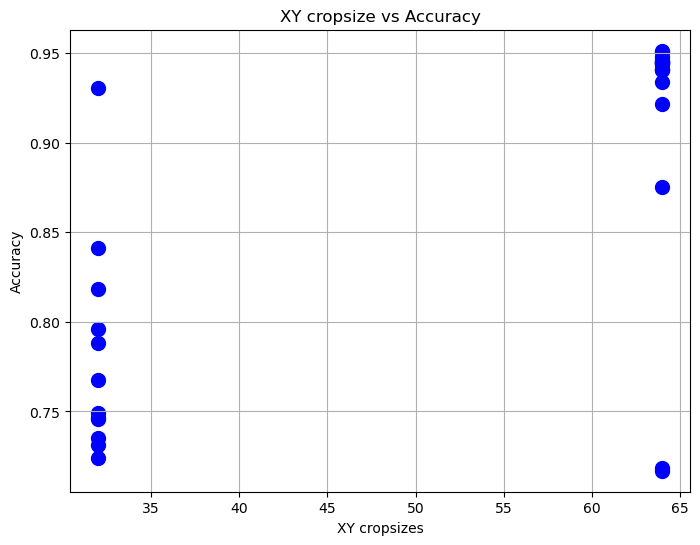

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["target_sz_xy"], final_dict["accuracy"], c='blue', s=100)

plt.title("XY cropsize vs Accuracy")
plt.xlabel("XY cropsizes")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

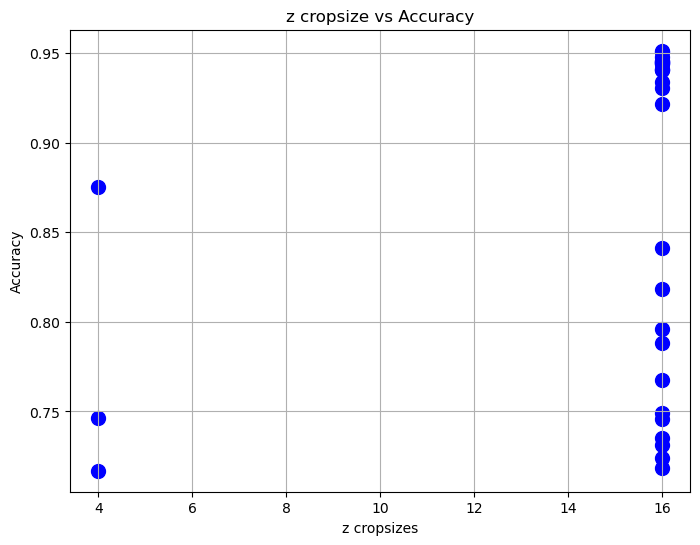

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["target_sz_z"], final_dict["accuracy"], c='blue', s=100)

plt.title("z cropsize vs Accuracy")
plt.xlabel("z cropsizes")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

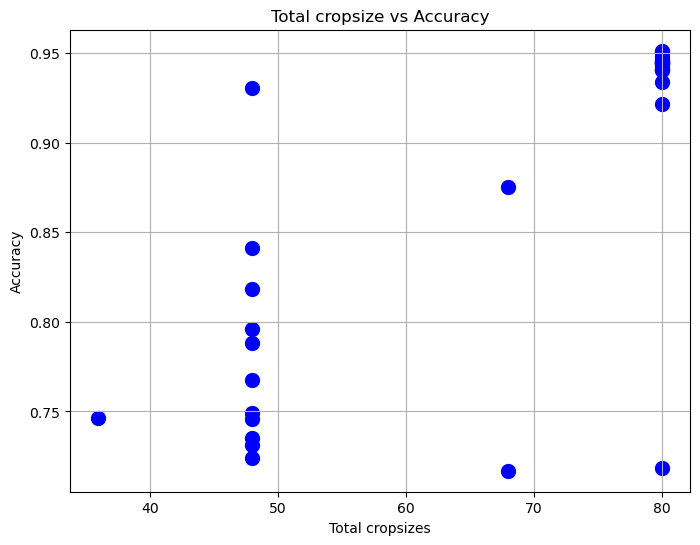

In [7]:
import numpy as np
plt.figure(figsize=(8, 6))
plt.scatter(np.array(final_dict["target_sz_z"])+np.array(final_dict["target_sz_xy"]), final_dict["accuracy"], c='blue', s=100)

plt.title("Total cropsize vs Accuracy")
plt.xlabel("Total cropsizes")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

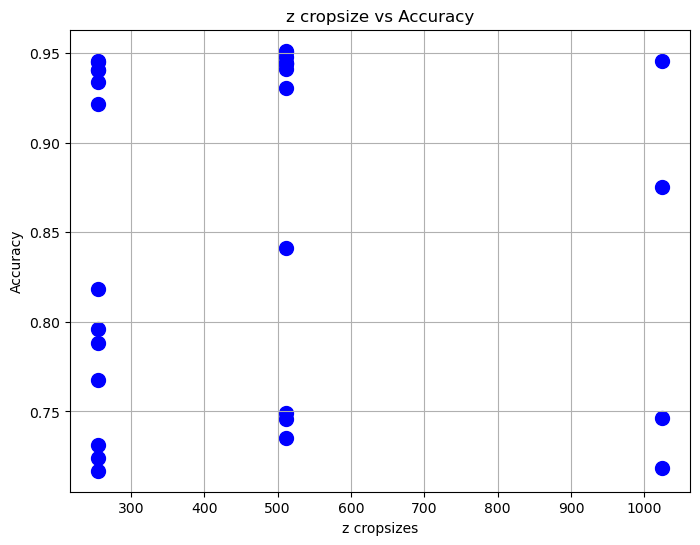

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["projector_final"], final_dict["accuracy"], c='blue', s=100)

plt.title("z cropsize vs Accuracy")
plt.xlabel("z cropsizes")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

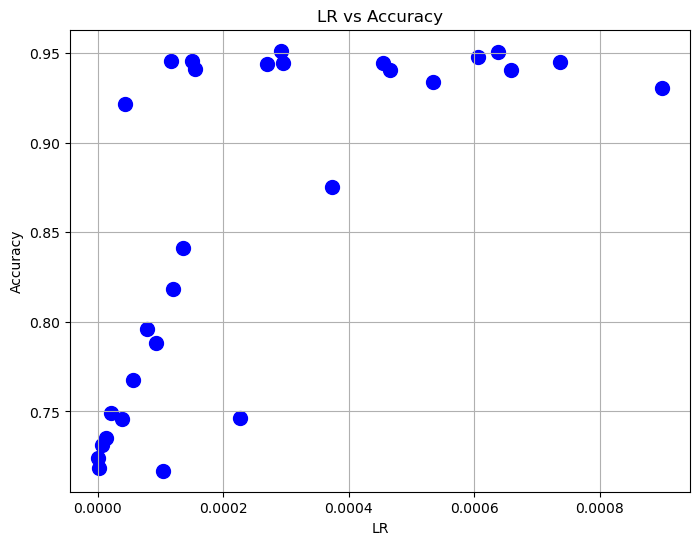

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["lr"], final_dict["accuracy"], c='blue', s=100)

plt.title("LR vs Accuracy")
plt.xlabel("LR")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [10]:
# Assume final_dict exists
# Get the sorting indices based on accuracy
sorted_indices = sorted(range(len(final_dict["accuracy"])), key=lambda i: final_dict["accuracy"][i])

# Reorder each list in the dictionary using the sorted indices
final_dict = {
    key: [value[i] for i in sorted_indices]
    for key, value in final_dict.items()
}


In [11]:
for triple in zip(final_dict["projector_final"], final_dict["target_sz_xy"], final_dict["target_sz_z"], final_dict["lr"]):
    print(triple)

(256, 64, 4, 0.00010364942220851687)
(1024, 64, 16, 1.998582666979759e-06)
(256, 32, 16, '1e-06')
(256, 32, 16, 6.862154746388041e-06)
(512, 32, 16, 1.295980350681241e-05)
(512, 32, 16, 3.8823369974777686e-05)
(1024, 32, 4, 0.00022734044323740042)
(512, 32, 16, 2.096678487878817e-05)
(256, 32, 16, 5.67627564420265e-05)
(256, 32, 16, 9.319986618969813e-05)
(256, 32, 16, 7.78987789892426e-05)
(256, 32, 16, 0.00011913397998738604)
(512, 32, 16, 0.0001361381640882188)
(1024, 64, 4, 0.0003726392162135063)
(256, 64, 16, 4.317628476347891e-05)
(512, 32, 16, 0.0008994919858009056)
(256, 64, 16, 0.0005338941341565084)
(256, 64, 16, 0.0004664834933305458)
(256, 64, 16, 0.0006583987311153104)
(512, 64, 16, 0.00015447391375736857)
(512, 64, 16, 0.0002691818542531716)
(512, 64, 16, 0.0004550583479595441)
(512, 64, 16, 0.0002950396591034747)
(256, 64, 16, 0.0007367575169423398)
(1024, 64, 16, 0.00011601671042106729)
(256, 64, 16, 0.00014944943190465187)
(512, 64, 16, 0.0006064213578665216)
(512, 64,

(array([  1.,   0.,   1.,   2.,   4.,   6.,   4.,  13.,  14., 118.]),
 array([0.58618182, 0.6271129 , 0.66804397, 0.70897505, 0.74990613,
        0.79083721, 0.83176828, 0.87269936, 0.91363044, 0.95456152,
        0.99549259]),
 <BarContainer object of 10 artists>)

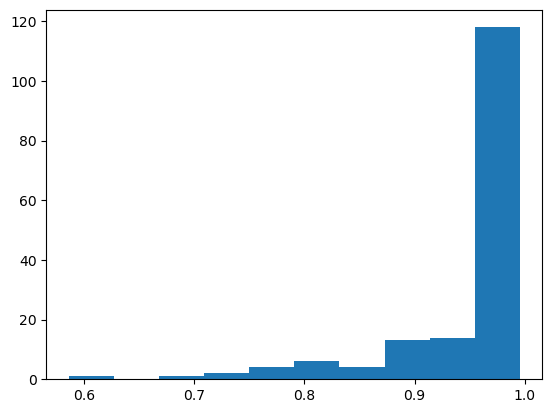

In [12]:
plt.hist(final_dict["per_neuron_accuracy"][-1].tolist())

(array([5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
        1.300e+01, 3.300e+01, 1.630e+02, 1.363e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

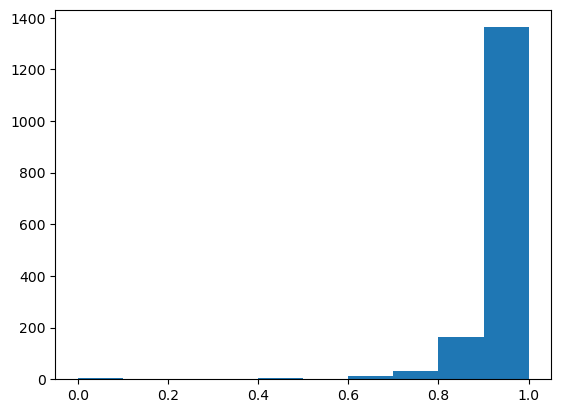

In [13]:
plt.hist(final_dict["per_timepoint_accuracy"][-2].tolist())

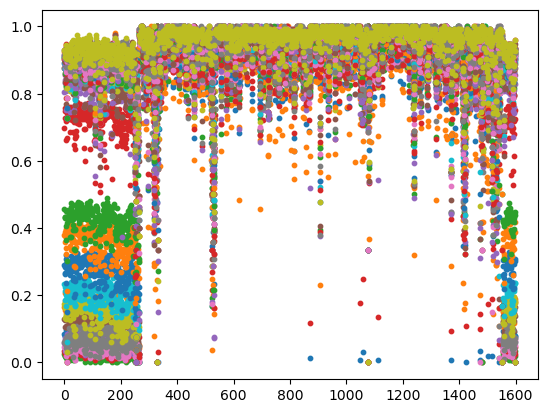

In [19]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][i])),final_dict["per_timepoint_accuracy"][i], s=10)

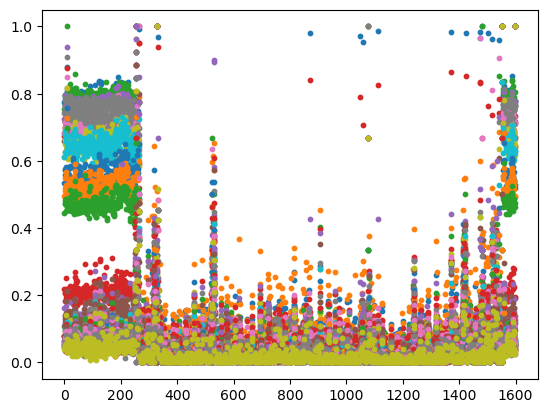

In [16]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][i])),final_dict["misses_per_timepoint_norm"][i], s=10)

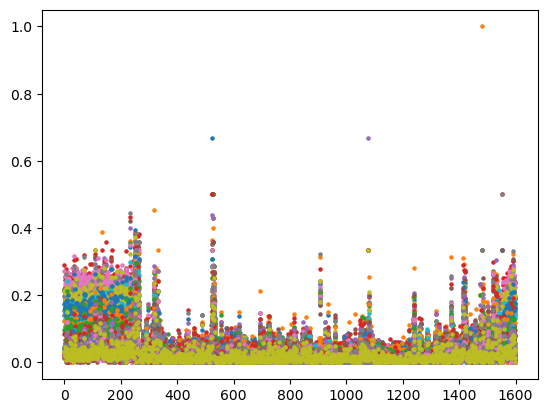

In [25]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][i])),final_dict["mismatches_per_timepoint_norm"][i], s=5)
